In [1]:
import scipy.io as sio
import numpy as np
import pickle as pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from scipy.signal import spectrogram
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from scipy import signal
import os

In [2]:
import tensorflow as tf
import keras

from tensorflow.keras.utils import to_categorical 
from keras.wrappers.scikit_learn import KerasClassifier
import keras.backend as K
from keras.models import Sequential, load_model
from keras.layers import Activation, Dropout, Flatten, Dense, LSTM, Conv2D, MaxPooling2D, RepeatVector
import warnings
warnings.filterwarnings('ignore')

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
os.getcwd()
os.chdir('/content/drive/My Drive')

In [5]:
_,_, files = next(os.walk('/content/drive/My Drive/MTech_Thesis/DENS/Emotional'))
files_count = len(files)

In [6]:
_,_, files1 = next(os.walk('/content/drive/My Drive/MTech_Thesis/DENS/NonEmotional'))
files_count = len(files1)

In [7]:
files1

['Neutral_mit003Trial-Click-.mat',
 'Neutral_mit004Trial-Click-.mat',
 'Neutral_mit007Trial-Click-.mat',
 'Neutral_mit014Trial-Click-.mat',
 'Neutral_mit017Trial-Click-.mat',
 'Neutral_mit022Trial-Click-.mat',
 'Neutral_mit023Trial-Click-.mat',
 'Neutral_mit024Trial-Click-.mat',
 'Neutral_mit032Trial-Click-.mat',
 'Neutral_mit035Trial-Click-.mat',
 'Neutral_mit039Trial-Click-.mat',
 'Neutral_mit040Trial-Click-.mat',
 'Neutral_mit051Trial-Click-.mat',
 'Neutral_mit052Trial-Click-.mat',
 'Neutral_mit054Trial-Click-.mat',
 'Neutral_mit061Trial-Click-.mat',
 'Neutral_mit067Trial-Click-.mat',
 'Neutral_mit072Trial-Click-.mat',
 'Neutral_mit074Trial-Click-.mat',
 'Neutral_mit076Trial-Click-.mat',
 'Neutral_mit079Trial-Click-.mat',
 'Neutral_mit080Trial-Click-.mat',
 'Neutral_mit081Trial-Click-.mat',
 'Neutral_mit082Trial-Click-.mat',
 'Neutral_mit096Trial-Click-.mat',
 'Neutral_mit097Trial-Click-.mat',
 'Neutral_mit099Trial-Click-.mat',
 'Neutral_mit106Trial-Click-.mat',
 'Neutral_mit107Tria

In [10]:
mat = sio.loadmat('/content/drive/My Drive/MTech_Thesis/DENS/NonEmotional/Neutral_mit104Trial-Click-.mat')
data1 = mat.get('eegData')

In [11]:
data1

array([[-0.7298584 , -0.853116  , -0.9761583 , ..., -1.5994216 ,
        -0.81162405, -0.22604097],
       [-0.09712679, -0.64489836, -1.1954851 , ..., -3.9191206 ,
        -3.2197666 , -2.4169416 ],
       [-0.22448984, -0.5714833 , -0.9429574 , ..., -4.141519  ,
        -3.3947153 , -2.5204613 ],
       ...,
       [-1.0040041 , -1.2581973 , -1.4648337 , ...,  0.5265562 ,
         1.1366749 ,  1.2002226 ],
       [-1.2087811 , -1.5810384 , -2.045014  , ...,  0.45293802,
         1.0603365 ,  0.9743938 ],
       [-0.8256112 , -1.3815207 , -2.0916946 , ...,  0.26711658,
         0.66468525,  0.45515677]], dtype=float32)

In [12]:
files

['Joyous_mit003Trial-2Click-1.mat',
 'Afraid_mit003Trial-6Click-2.mat',
 'Angry_mit003Trial-7Click-4.mat',
 'Hate_mit003Trial-7Click-3.mat',
 'Hate_mit003Trial-10Click-6.mat',
 'Alarmed_mit003Trial-9Click-5.mat',
 'Sad_mit003Trial-11Click-7.mat',
 'Amused_mit004Trial-3Click-1.mat',
 'Adventorous_mit004Trial-4Click-3.mat',
 'Excited_mit004Trial-4Click-2.mat',
 'Disgust_mit004Trial-5Click-4.mat',
 'Disgust_mit004Trial-5Click-5.mat',
 'Happy_mit004Trial-8Click-6.mat',
 'Happy_mit004Trial-8Click-7.mat',
 'Taken Aback_mit004Trial-11Click-9.mat',
 'Distress_mit007Trial-3Click-2.mat',
 'Miserable_mit007Trial-2Click-1.mat',
 'Despondent_mit007Trial-4Click-4.mat',
 'Miserable_mit007Trial-4Click-3.mat',
 'Happy_mit007Trial-7Click-6.mat',
 'Hate_mit007Trial-5Click-5.mat',
 'Joyous_mit007Trial-7Click-7.mat',
 'Calm_mit014Trial-1Click-1.mat',
 'Pensive_mit014Trial-1Click-3.mat',
 'Pensive_mit014Trial-1Click-2.mat',
 'Amused_mit014Trial-2Click-4.mat',
 'Excited_mit014Trial-2Click-5.mat',
 'Amused_mi

In [8]:
rating = pd.read_csv('/content/drive/My Drive/MTech_Thesis/DENS/Rating/wholeFrequencyDependentDataWithVADLFR_ReFormattingWholeFrequencyVA - wholeFrequencyDependentDataWithVADLFR_ReFormattingWholeFrequencyVA.csv')

In [24]:
eeg_data = []
eeg_label = []

In [25]:
def label_mapping(valence, arousal):
    # HVHA, HVLA, LVHA, and LVLA
    
    if (valence <= 4.5):
        label = 0 
    elif (valence > 4.5 and valence < 5.5):
        label = -1
    elif (valence >= 5.5):
        label = 2
    
    return label

In [26]:
base_path = "/content/drive/My Drive/MTech_Thesis/DENS/Emotional/"
for f in files:
  if f.endswith(".mat"):
    file_str = f[:-4]
    df = rating[rating["Subject"].str.contains(file_str)]
    if not df.empty:
      path = base_path + f
      mat = sio.loadmat(path)
      data = mat.get('eegData')
      df = df[['Subject','valence','arousal']]
      df = df.drop_duplicates()
      valence = df['valence']
      arousal = df['arousal']
      lab = label_mapping(valence.values[0], arousal.values[0])
      if lab != -1:
        eeg_data.append(data)
        eeg_label.append(lab)

In [27]:
base_path_n = "/content/drive/My Drive/MTech_Thesis/DENS/NonEmotional/"
for f in files1:
  if f.endswith(".mat"):
    file_str = f[:-4]
    path = base_path_n + f
    mat = sio.loadmat(path)
    data = mat.get('eegData')
    eeg_data.append(data)
    eeg_label.append('1')

In [30]:
eeg_data = np.array(eeg_data)

In [31]:
eeg_data.shape

(487, 128, 1751)

In [32]:
eeg_label = np.array(eeg_label)

In [37]:
eeg_label

array(['2', '0', '0', '0', '0', '0', '0', '2', '2', '2', '0', '0', '2',
       '2', '0', '0', '0', '0', '0', '2', '0', '2', '2', '2', '2', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '2', '2', '2', '2', '0',
       '0', '0', '0', '0', '2', '2', '0', '0', '0', '0', '0', '0', '2',
       '0', '0', '0', '0', '2', '0', '0', '0', '0', '0', '0', '0', '2',
       '2', '0', '2', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '2', '0', '2', '2', '2', '2', '0', '0', '0', '0', '0', '0', '2',
       '2', '2', '0', '0', '2', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '2', '2', '0', '2', '2', '2', '2', '2', '2', '2', '0', '0',
       '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0',
       '0', '0', '0', '2', '2', '2', '0', '0', '0', '0', '0', '2', '2',
       '2', '2', '2', '2', '2', '0', '0', '0', '0', '2', '0', '0

In [38]:
eeg_Label = []
for i in eeg_label:
    for j in range (0,128):
        eeg_Label.append(i)

In [40]:
eeg_Label = np.array(eeg_Label)

In [41]:
eeg_Label.shape

(62336,)

In [49]:
eeg_Label = eeg_Label.astype('int32')

In [50]:
count0 = np.count_nonzero(eeg_Label == 0)
count1 = np.count_nonzero(eeg_Label == 1)
count2 = np.count_nonzero(eeg_Label == 2)

In [51]:
print(count0)
print(count1)
print(count2)

40576
5120
16640


In [62]:
zero_weight = 0.51
one_weight = 4.06
two_weight = 1.25

In [52]:
from tensorflow.keras.utils import to_categorical 
y = to_categorical(eeg_Label)

In [53]:
y.shape

(62336, 3)

In [42]:
import functools
def combine_dims(a, i=0, n=1):
  s = list(a.shape)
  combined = functools.reduce(lambda x,y: x*y, s[i:i+n+1])
  return np.reshape(a, s[:i] + [combined] + s[i+n+1:])

In [43]:
eeg_Data = combine_dims(np.array(eeg_data), 0)

In [44]:
eeg_Data.shape

(62336, 1751)

In [54]:
fs = 250

size_dataset = len(eeg_Data)
nperseg = 125
noverlap = 62
f_size = int((nperseg + 1)/2)
t_size = int((eeg_Data[0].size - noverlap ) / (nperseg - noverlap))
X_full = np.ndarray(shape=(size_dataset, f_size, t_size, 3))                     
for i in range(0, size_dataset):
  for j in range(0,3):
    X = eeg_Data[i] 
    f, t, Sxx = spectrogram(X, fs, nperseg = nperseg, noverlap = noverlap, mode='psd')
    X_full[i, :, :, j] = Sxx

In [55]:
X_full = np.array(X_full)

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.2, random_state=23)

In [57]:
X_train /= 255
X_test /= 255

In [58]:
num_classes = 3 

In [59]:
input_shape = (X_train.shape[1],X_train.shape[2],X_train.shape[3])
input_shape

(63, 26, 3)

In [60]:
model = Sequential()

model.add(Conv2D(32, (3, 3), 
          strides=(1, 1),
          activation='relu', 
          input_shape=input_shape))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(Conv2D(64, (3, 3), 
          activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.1))

model.add(Flatten())

model.add(RepeatVector(3))

model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(128))
model.add(Dropout(0.2))

model.add(Dense(64, activation="relu"))
model.add(Dropout(0.2))


model.add(Dense(num_classes, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 61, 24, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 12, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 10, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 5, 64)        0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 14, 5, 64)         0         
                                                                 
 flatten (Flatten)           (None, 4480)              0

In [63]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
mc = tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
model.compile(optimizer ="Adam", loss =keras.losses.categorical_crossentropy, metrics=['accuracy'])

m=model.fit(X_train, y_train,epochs=100,batch_size=256,verbose=1,validation_data=(X_test, y_test),class_weight={0:zero_weight, 1:one_weight, 2: two_weight}, callbacks =[es, mc])

Epoch 1/100
195/195 [==============================] - ETA: 0s - loss: 1.0884 - accuracy: 0.3189
Epoch 1: val_accuracy improved from -inf to 0.61742, saving model to best_model.h5
195/195 [==============================] - 29s 71ms/step - loss: 1.0884 - accuracy: 0.3189 - val_loss: 1.0293 - val_accuracy: 0.6174
Epoch 2/100
193/195 [============================>.] - ETA: 0s - loss: 1.0219 - accuracy: 0.4238
Epoch 2: val_accuracy did not improve from 0.61742
195/195 [==============================] - 4s 19ms/step - loss: 1.0216 - accuracy: 0.4241 - val_loss: 0.9699 - val_accuracy: 0.5293
Epoch 3/100
193/195 [============================>.] - ETA: 0s - loss: 0.9518 - accuracy: 0.4822
Epoch 3: val_accuracy did not improve from 0.61742
195/195 [==============================] - 4s 19ms/step - loss: 0.9518 - accuracy: 0.4831 - val_loss: 0.9921 - val_accuracy: 0.4838
Epoch 4/100
193/195 [============================>.] - ETA: 0s - loss: 0.8932 - accuracy: 0.5067
Epoch 4: val_accuracy did not 

In [64]:
saved_model = load_model('best_model.h5')

In [65]:
_, train_f1 = saved_model.evaluate(X_train, y_train, verbose=0)
_, test_f1 = saved_model.evaluate(X_test, y_test, verbose=0)

In [66]:
print(test_f1)

0.9764998555183411


In [67]:
y_pred_saved = saved_model.predict(X_test)

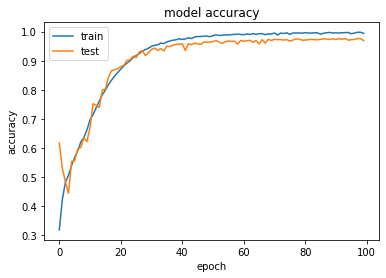

In [68]:
import matplotlib.pyplot as plt
plt.plot(m.history['accuracy'])
plt.plot(m.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [69]:
y_test1=np.argmax(y_test, axis=1)
y_pred_saved=np.argmax(y_pred_saved,axis=1)

In [70]:
f_score = f1_score(y_test1,y_pred_saved, average = 'weighted')

In [71]:
print(f_score)

0.9764398769153928


In [72]:
cf_matrix=confusion_matrix(y_test1, y_pred_saved)

In [73]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from matplotlib.collections import QuadMesh


def get_new_fig(fn, figsize=[8, 8]):
    """Init graphics"""
    fig1 = plt.figure(fn, figsize)
    ax1 = fig1.gca()  # Get Current Axis
    ax1.cla()  # clear existing plot
    return fig1, ax1


def configcell_text_and_colors(
    array_df, lin, col, oText, facecolors, posi, fz, fmt, show_null_values=0
):
    """
    config cell text and colors
    and return text elements to add and to dell
    @TODO: use fmt
    """
    text_add = []
    text_del = []
    cell_val = array_df[lin][col]
    tot_all = array_df[-1][-1]
    per = (float(cell_val) / tot_all) * 100
    curr_column = array_df[:, col]
    ccl = len(curr_column)
    
    # last line  and/or last column
    if (col == (ccl - 1)) or (lin == (ccl - 1)):
        # tots and percents
        if cell_val != 0:
            if (col == ccl - 1) and (lin == ccl - 1):
                tot_rig = 0
                for i in range(array_df.shape[0] - 1):
                    tot_rig += array_df[i][i]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif col == ccl - 1:
                tot_rig = array_df[lin][lin]
                per_ok = (float(tot_rig) / cell_val) * 100
            
            elif lin == ccl - 1:
                tot_rig = array_df[col][col]
                per_ok = (float(tot_rig) / cell_val) * 100
            #per_err = 100 - per_ok
            
        else:
            per_ok = 0
            #per_ok = per_err = 0
            

        per_ok_s = ["%.2f%%" % (per_ok), "100%"][per_ok == 100]

        # text to DEL
        text_del.append(oText)

        # text to ADD
        font_prop = fm.FontProperties(weight="bold", size=22)
        text_kwargs = dict(
            color="w",
            ha="center",
            va="center",
            gid="sum",
            fontproperties=font_prop,
        )
        #lis_txt = ["%d" % (cell_val), per_ok_s, "%.2f%%" % (per_err)]
        lis_txt = ["%d" % (cell_val), per_ok_s]
        lis_kwa = [text_kwargs]
        dic = text_kwargs.copy()
        dic["color"] = "w"
        lis_kwa.append(dic)
        dic = text_kwargs.copy()
        dic["color"] = "w"
        lis_kwa.append(dic)
        '''
        lis_pos = [
            (oText._x, oText._y - 0.3),
            (oText._x, oText._y),
            (oText._x, oText._y + 0.3),
        ]
        '''
        lis_pos = [
            (oText._x, oText._y - 0.1),
            (oText._x, oText._y + 0.1),
        ]
        for i in range(len(lis_txt)):
            newText = dict(
                x=lis_pos[i][0],
                y=lis_pos[i][1],
                text=lis_txt[i],
                kw=lis_kwa[i],
            )
            text_add.append(newText)

        # set background color for sum cells (last line and last column)
        carr = [0.27, 0.30, 0.27, 1.0]
        if (col == ccl - 1) and (lin == ccl - 1):
            carr = [0.17, 0.20, 0.17, 1.0]
        facecolors[posi] = carr

    else:
        if per > 0:
            txt = "%s\n%.2f%%" % (cell_val, per)
        else:
            if show_null_values == 0:
                txt = "0\n0.0%"
            elif show_null_values == 1:
                txt = "0"
            else:
                txt = "0\n0.0%"
        oText.set_text(txt)

        # main diagonal
        if col == lin:
            # set color of the textin the diagonal to white
            oText.set_color("w")
            # set background color in the diagonal to blue
            facecolors[posi] = [0.35, 0.8, 0.55, 1.0]
        else:
            oText.set_color("r")

    return text_add, text_del


def insert_totals(df_cm):
    """insert total column and line (the last ones)"""
    sum_col = []
    for c in df_cm.columns:
        sum_col.append(df_cm[c].sum())
    sum_lin = []
    for item_line in df_cm.iterrows():
        sum_lin.append(item_line[1].sum())
    df_cm["sum_lin"] = sum_lin
    sum_col.append(np.sum(sum_lin))
    df_cm.loc["sum_col"] = sum_col


def pp_matrix_tej(
    df_cm,
    annot=True,
    cmap="Oranges",
    fmt=".2f",
    fz=22,
    lw=0.5,
    cbar=False,
    figsize=[12, 12],
    show_null_values=0,
    pred_val_axis="y",
):
    """
    print conf matrix with default layout (like matlab)
    params:
      df_cm          dataframe (pandas) without totals
      annot          print text in each cell
      cmap           Oranges,Oranges_r,YlGnBu,Blues,RdBu, ... see:
      fz             fontsize
      lw             linewidth
      pred_val_axis  where to show the prediction values (x or y axis)
                      'col' or 'x': show predicted values in columns (x axis) instead lines
                      'lin' or 'y': show predicted values in lines   (y axis)
    """
    if pred_val_axis in ("col", "x"):
        xlbl = "Predicted"
        ylbl = "Actual"
    else:
        xlbl = "Actual"
        ylbl = "Predicted"
        df_cm = df_cm.T

    # create "Total" column
    insert_totals(df_cm)

    # this is for print allways in the same window
    fig, ax1 = get_new_fig("Conf matrix default", figsize)

    ax = sn.heatmap(
        df_cm,
        annot=annot,
        annot_kws={"size": 22, "weight": "bold"},
        linewidths=lw,
        ax=ax1,
        cbar=cbar,
        cmap=cmap,
        linecolor="w",
        fmt=fmt,
    )

    # set ticklabels rotation
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, fontsize=22, fontweight = "bold")
    ax.set_yticklabels(ax.get_yticklabels(), rotation=90, fontsize=22, fontweight = "bold")

    # Turn off all the ticks
    for t in ax.xaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False
    for t in ax.yaxis.get_major_ticks():
        t.tick1On = False
        t.tick2On = False

    # face colors list
    quadmesh = ax.findobj(QuadMesh)[0]
    facecolors = quadmesh.get_facecolors()

    # iter in text elements
    array_df = np.array(df_cm.to_records(index=False).tolist())
    text_add = []
    text_del = []
    posi = -1  # from left to right, bottom to top.
    for t in ax.collections[0].axes.texts:  # ax.texts:
        pos = np.array(t.get_position()) - [0.5, 0.5]
        lin = int(pos[1])
        col = int(pos[0])
        posi += 1
        #print(t)
        #print(pos)
        # set text
        txt_res = configcell_text_and_colors(
            array_df, lin, col, t, facecolors, posi, fz, fmt, show_null_values
        )
        #print(txt_res)
        text_add.extend(txt_res[0])
        text_del.extend(txt_res[1])

    # remove the old ones
    for item in text_del:
        item.remove()
    # append the new ones
    for item in text_add:
        ax.text(item["x"], item["y"], item["text"], **item["kw"])

    # titles and legends
    ax.set_title("Confusion matrix", fontsize=22, fontweight = "bold")
    ax.set_xlabel(xlbl, fontsize=22, labelpad=1, fontweight = "bold")
    ax.set_ylabel(ylbl, fontsize=22, labelpad=1, fontweight = "bold")
    #plt.tight_layout()  # set layout slim
    plt.savefig('dens_confusion_3val_ne.pdf', dpi=300)
    plt.show()


def pp_matrix_from_data(
    y_test,
    predictions,
    columns=None,
    annot=True,
    cmap="Oranges",
    fmt=".2f",
    fz=22,
    lw=0.5,
    cbar=False,
    figsize=[8, 8],
    show_null_values=0,
    pred_val_axis="lin",
):
    """
    plot confusion matrix function with y_test (actual values) and predictions (predic),
    whitout a confusion matrix yet
    """
    from pandas import DataFrame
    from sklearn.metrics import confusion_matrix

    # data
    if not columns:
        from string import ascii_uppercase

        columns = [
            "class %s" % (i)
            for i in list(ascii_uppercase)[0 : len(np.unique(y_test))]
        ]

    confm = confusion_matrix(y_test, predictions)
    fz = 22
    figsize = [8, 8]
    show_null_values = 2
    df_cm = DataFrame(confm, index=columns, columns=columns)
    pp_matrix_tej(
        df_cm,
        fz=fz,
        cmap=cmap,
        figsize=figsize,
        show_null_values=show_null_values,
        pred_val_axis=pred_val_axis,
    )

In [74]:
df_cm = pd.DataFrame(cf_matrix, index=range(0, 3), columns=range(0, 3))

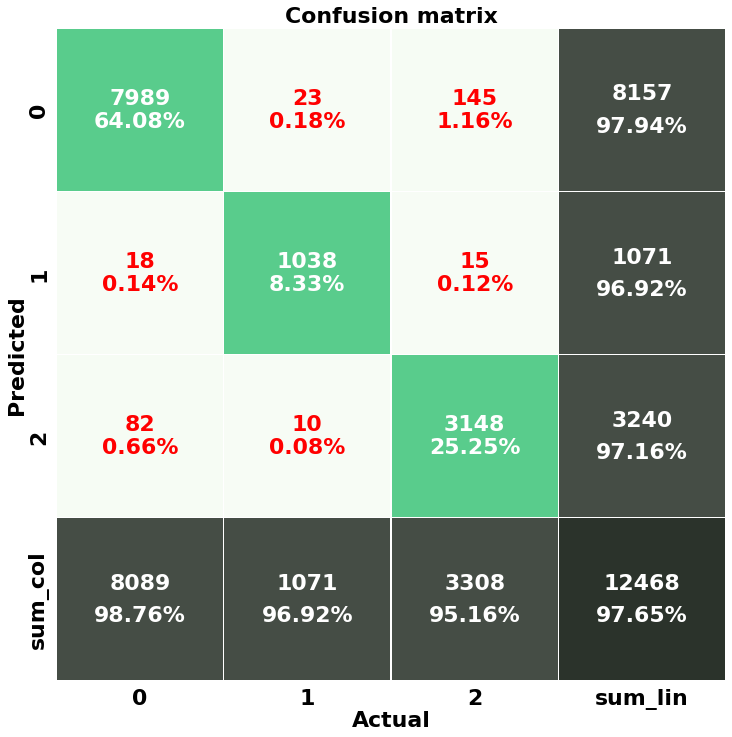

In [75]:
pp_matrix_tej(df_cm,cmap = 'Greens',annot=True, lw=0.5, show_null_values=0)

In [76]:
from sklearn import metrics
print(metrics.classification_report(y_test1,y_pred_saved))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      8089
           1       0.97      0.97      0.97      1071
           2       0.97      0.95      0.96      3308

    accuracy                           0.98     12468
   macro avg       0.97      0.97      0.97     12468
weighted avg       0.98      0.98      0.98     12468



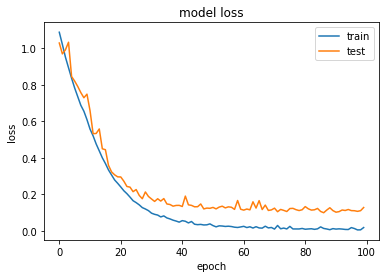

In [77]:
plt.plot(m.history['loss'])
plt.plot(m.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()